<a href="https://colab.research.google.com/github/dbengp/Data_Science_Alura_Challenges_Projeto_Final/blob/main/Projeto_Data_Science_Alura_Challenge_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução
"""
# Desafio Telecom X - Parte 2: Prevendo a Evasão de Clientes (Churn)

### Missão do Cientista de Dados

Após a análise exploratória de dados (EDA) bem-sucedida, fui promovido a Analista de Machine Learning Júnior. Minha nova missão é construir modelos preditivos para prever quais clientes da Telecom X têm maior probabilidade de cancelar seus serviços.

O objetivo é transformar os insights do passado em uma ferramenta proativa para a empresa, permitindo que ela identifique clientes de risco e tome medidas para retê-los.

---

### Mão na Massa

O projeto será dividido nas seguintes etapas:

1.  **Importação de Bibliotecas e Dados:** Carregamento das bibliotecas necessárias e dos dados já tratados.
2.  **Pré-processamento dos Dados:** Preparação do dataset para a modelagem, incluindo codificação de variáveis categóricas e tratamento de colunas desnecessárias.
3.  **Análise e Seleção de Variáveis:** Verificação da correlação e das relações entre as variáveis.
4.  **Modelagem Preditiva:**
    * Divisão do dataset em treino e teste.
    * Criação e treinamento de dois modelos de classificação.
5.  **Avaliação dos Modelos:** Análise crítica do desempenho de cada modelo usando métricas-chave.
6.  **Interpretação e Conclusão:** Análise da importância das variáveis e elaboração de um relatório final com insights estratégicos.
"""

In [7]:
# Importação de Bibliotecas e Normalização dos Dados
"""
## 1. Importação de Bibliotecas e Normalização dos Dados

Nesta etapa, vamos carregar o dataset original em formato JSON e normalizá-lo para que as colunas fiquem em um formato tabular, ideal para a modelagem preditiva.

Usaremos a função `pd.json_normalize` para 'achatar' a estrutura aninhada do JSON.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

# As funções de normalização agora são um método de alto nível de pandas
# Não é necessário fazer "from pandas.io.json import json_normalize"

# Configurando o estilo dos gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# URL do dataset original em formato JSON
url_json = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json"

try:
    df_json = pd.read_json(url_json)
    print("Dados JSON extraídos com sucesso!")
except Exception as e:
    print(f"Erro ao extrair os dados JSON: {e}. Verifique a URL.")

# Normalizando o JSON aninhado para criar um DataFrame plano
# Extraindo as chaves aninhadas 'customer', 'phone', 'internet' e 'account'
df_normalized = pd.json_normalize(df_json.to_dict('records'), sep='_')

print("\nDados normalizados com sucesso!")
print("\nPrimeiras 5 linhas do DataFrame normalizado:")
print(df_normalized.head())
print("\nInformações sobre os tipos de dados (após a normalização):")
df_normalized.info()

Dados JSON extraídos com sucesso!

Dados normalizados com sucesso!

Primeiras 5 linhas do DataFrame normalizado:
   customerID Churn customer_gender  customer_SeniorCitizen customer_Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer_Dependents  customer_tenure phone_PhoneService phone_MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4

In [10]:
# Pré-processamento dos Dados para Modelagem
"""
## 2. Pré-processamento dos Dados para Modelagem

Nesta etapa, vamos preparar os dados para os modelos de machine learning.

* **Tratamento da Variável-Alvo:** A variável 'Churn' será convertida de 'Yes'/'No' para 1/0.
* **Tratamento de 'Charges_Total':** A coluna de gastos totais será convertida para o tipo numérico, e os valores nulos serão preenchidos.
* **Codificação de Variáveis Categóricas:** Aplicaremos o One-Hot Encoding nas colunas categóricas restantes.
* **Remoção de Colunas:** A coluna 'customerID' é um identificador único e será removida.
"""

# Criando uma cópia do DataFrame para as transformações
df_final = df_normalized.copy()

# 2.1. Remover a coluna 'customerID'
df_final = df_final.drop(columns=['customerID'])
print("Coluna 'customerID' removida.")

# 2.2. Tratar a coluna 'account_Charges_Total'
# Substituindo espaços por nulos e convertendo para numérico
df_final['account_Charges_Total'] = df_final['account_Charges_Total'].replace(' ', np.nan, regex=True).astype(float)
# Preenchendo os valores nulos com a média da coluna
df_final['account_Charges_Total'] = df_final['account_Charges_Total'].fillna(df_final['account_Charges_Total'].mean())
print("Coluna 'account_Charges_Total' tratada e convertida para tipo numérico.")

# 2.3. Tratar e mapear a variável-alvo 'Churn' para 0 e 1
# Removendo linhas com valores inconsistentes na coluna 'Churn' antes da conversão
df_final['Churn'] = df_final['Churn'].replace('', np.nan)
df_final.dropna(subset=['Churn'], inplace=True)
print(f"Foram removidas {df_normalized.shape[0] - df_final.shape[0]} linhas com valores inconsistentes na coluna 'Churn'.")

# Mapeando 'Yes'/'No' para 1/0
df_final['Churn'] = df_final['Churn'].map({'Yes': 1, 'No': 0}).astype(int)
print("Variável 'Churn' mapeada para 1 (sim) e 0 (não).")

# 2.4. Aplicar One-Hot Encoding nas variáveis categóricas
# Selecionando apenas as colunas com tipo de dado 'object'
colunas_categoricas = df_final.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df_final, columns=colunas_categoricas, dtype=int)

print("\nDataFrame com variáveis categóricas codificadas e estrutura correta:")
print(df_encoded.head())

# 2.5. Avaliar o balanceamento das classes
print("\nDimensões do novo DataFrame:", df_encoded.shape)
print("\nDistribuição da variável-alvo 'Churn':")
print(df_encoded['Churn'].value_counts(normalize=True))

if df_encoded['Churn'].value_counts(normalize=True)[1] < 0.3:
    print("\n⚠️ Atenção: A base de dados está desbalanceada. Isso pode impactar o desempenho do modelo.")
    print("Para um projeto mais avançado, técnicas como SMOTE seriam recomendadas para balanceamento.")
else:
    print("\n✅ O desbalanceamento não é um problema significativo para esta análise.")

Coluna 'customerID' removida.
Coluna 'account_Charges_Total' tratada e convertida para tipo numérico.
Foram removidas 224 linhas com valores inconsistentes na coluna 'Churn'.
Variável 'Churn' mapeada para 1 (sim) e 0 (não).

DataFrame com variáveis categóricas codificadas e estrutura correta:
   Churn  customer_SeniorCitizen  customer_tenure  account_Charges_Monthly  \
0      0                       0                9                     65.6   
1      0                       0                9                     59.9   
2      1                       0                4                     73.9   
3      1                       1               13                     98.0   
4      1                       1                3                     83.9   

   account_Charges_Total  customer_gender_Female  customer_gender_Male  \
0                 593.30                       1                     0   
1                 542.40                       0                     1   
2              

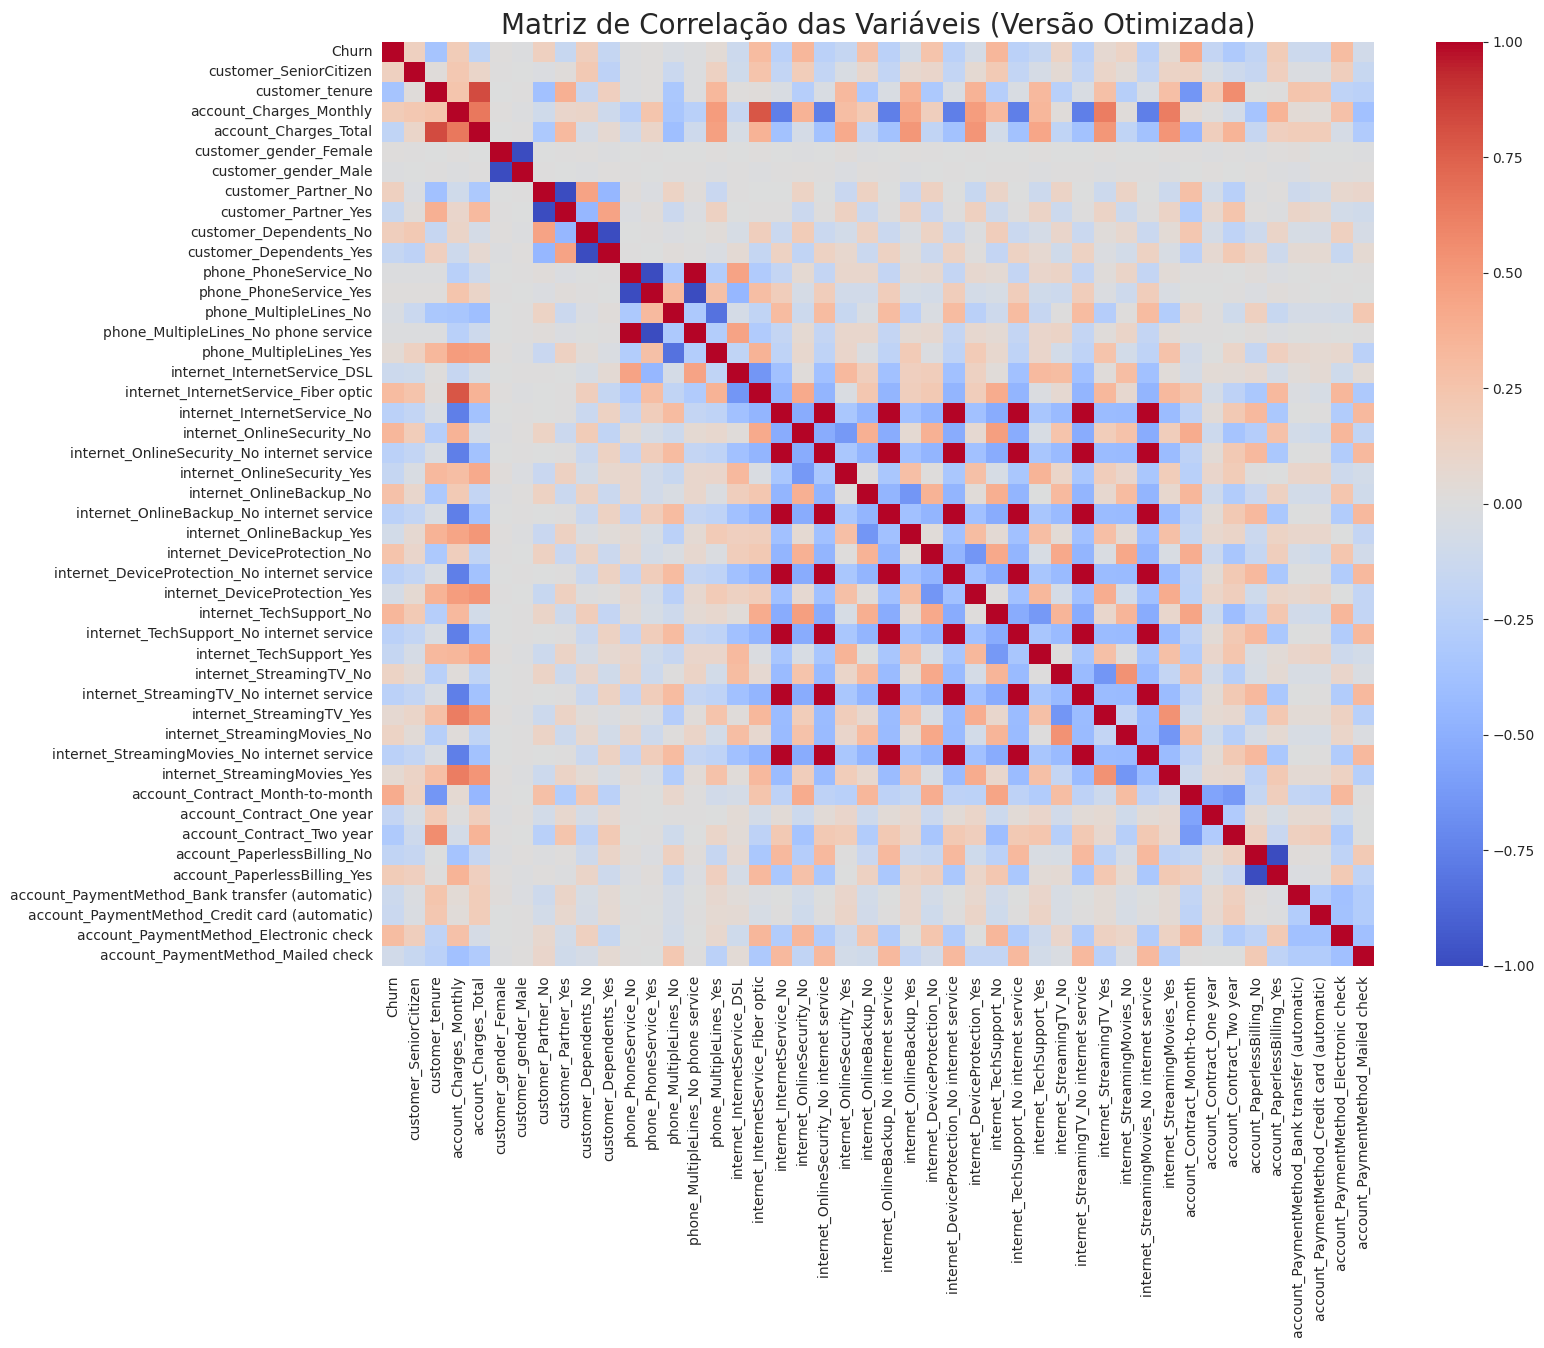

Correlação das variáveis com 'Churn':
Churn                                     1.000000
account_Contract_Month-to-month           0.405103
internet_OnlineSecurity_No                0.342637
internet_TechSupport_No                   0.337281
internet_InternetService_Fiber optic      0.308020
account_PaymentMethod_Electronic check    0.301919
internet_OnlineBackup_No                  0.268005
internet_DeviceProtection_No              0.252481
account_Charges_Monthly                   0.193356
account_PaperlessBilling_Yes              0.191825
customer_Dependents_No                    0.164221
customer_SeniorCitizen                    0.150889
customer_Partner_No                       0.150448
internet_StreamingMovies_No               0.130845
internet_StreamingTV_No                   0.128916
Name: Churn, dtype: float64


In [11]:
# Análise e Seleção de Variáveis
"""
## 3. Análise e Seleção de Variáveis

Vamos visualizar a matriz de correlação para entender as relações entre as variáveis numéricas, incluindo a variável-alvo `Churn`.
"""
# Análise de Correlação com o novo DataFrame
plt.figure(figsize=(16, 12))
matriz_correlacao = df_encoded.corr()
sns.heatmap(matriz_correlacao, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação das Variáveis (Versão Otimizada)', fontsize=20)
plt.show()

# Correlação com a variável 'Churn'
correlacao_churn = matriz_correlacao['Churn'].sort_values(ascending=False)
print("Correlação das variáveis com 'Churn':")
print(correlacao_churn.head(15))

In [12]:
# Modelagem Preditiva
"""
## 4. Modelagem Preditiva

Nesta etapa, vamos dividir os dados e treinar dois modelos de classificação para prever o churn.

* **Modelo 1:** Regressão Logística (requer normalização)
* **Modelo 2:** Random Forest (não requer normalização)
"""

# 4.1. Separar dados em features (X) e target (y)
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

# 4.2. Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4.3. Modelo 1: Regressão Logística com Pipeline
print("--- Treinando Modelo de Regressão Logística ---")
pipeline_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

pipeline_logreg.fit(X_train, y_train)
y_pred_logreg = pipeline_logreg.predict(X_test)
print("Modelo de Regressão Logística treinado com sucesso!")

# 4.4. Modelo 2: Random Forest Classifier
print("\n--- Treinando Modelo de Random Forest ---")
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print("Modelo de Random Forest treinado com sucesso!")

--- Treinando Modelo de Regressão Logística ---
Modelo de Regressão Logística treinado com sucesso!

--- Treinando Modelo de Random Forest ---
Modelo de Random Forest treinado com sucesso!


--- Avaliação do Modelo de Regressão Logística ---
Acurácia: 0.8164
Precisão: 0.6760
Recall: 0.5681
F1-Score: 0.6174


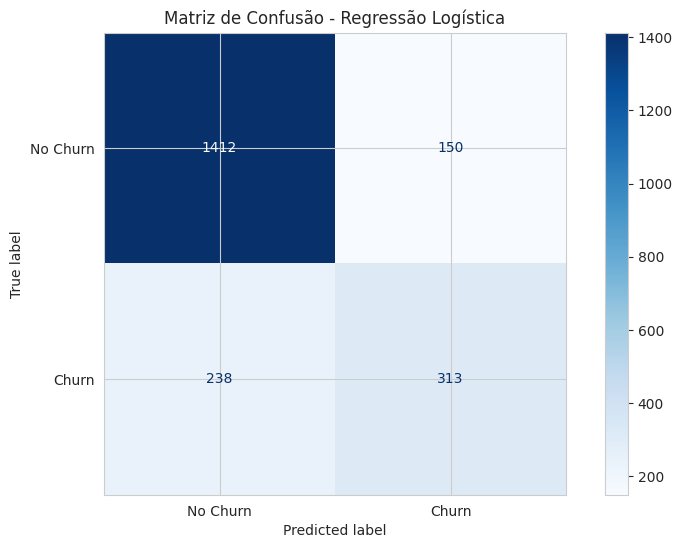


--- Avaliação do Modelo de Random Forest ---
Acurácia: 0.7823
Precisão: 0.6102
Recall: 0.4574
F1-Score: 0.5228


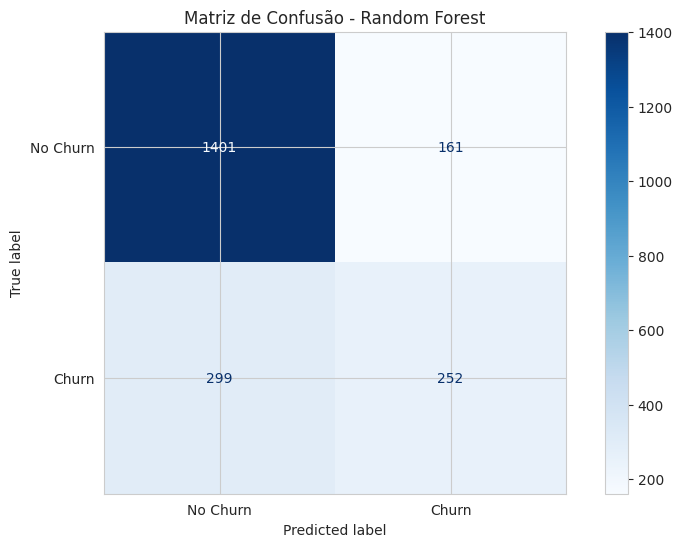

In [15]:
# Avaliação de Modelos
"""
## 5. Avaliação dos Modelos

Nesta etapa, vamos avaliar o desempenho dos modelos de Regressão Logística e Random Forest usando métricas de classificação.
"""

# 5.1. Avaliação do Modelo de Regressão Logística
print("--- Avaliação do Modelo de Regressão Logística ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_logreg):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_logreg):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_logreg):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_logreg):.4f}")

# Exibir a Matriz de Confusão para Regressão Logística
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=['No Churn', 'Churn'])
disp_logreg.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Regressão Logística')
plt.show()


# 5.2. Avaliação do Modelo de Random Forest
print("\n--- Avaliação do Modelo de Random Forest ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")

# Exibir a Matriz de Confusão para Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['No Churn', 'Churn'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Random Forest')
plt.show()

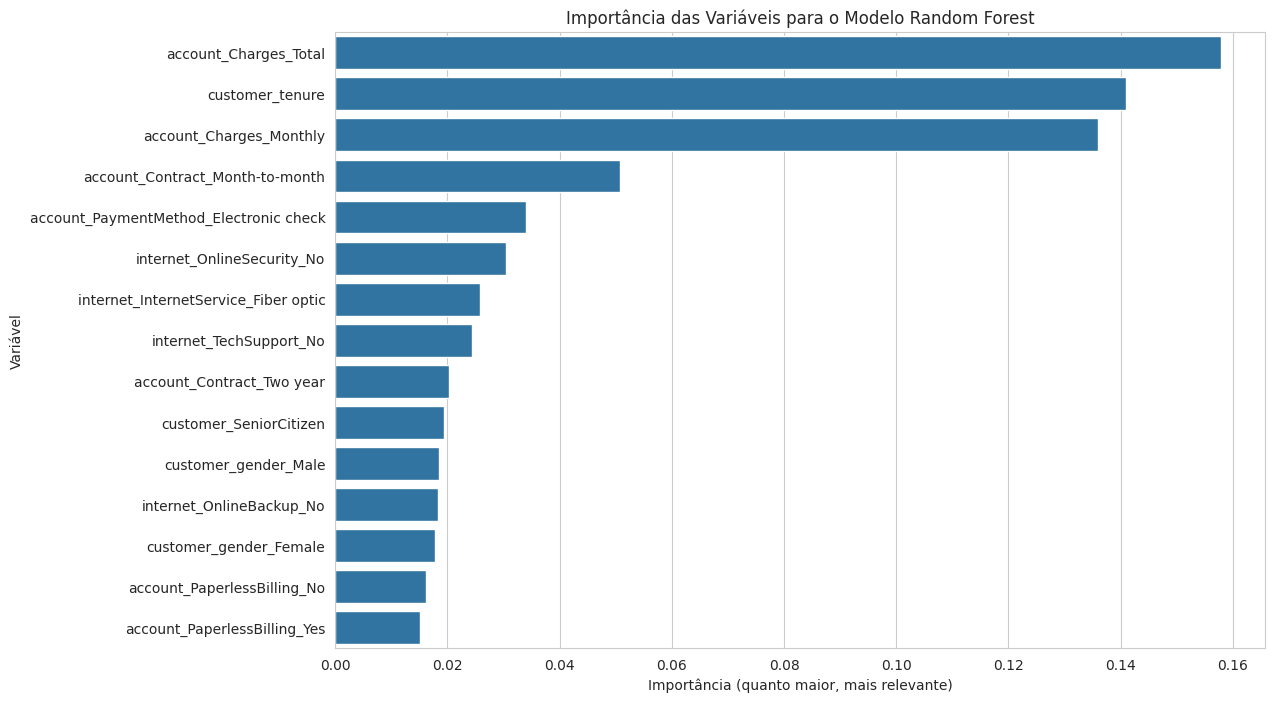

In [16]:
# Interpretação e Conclusão
"""
## 6. Interpretação e Conclusão

### Qual modelo teve o melhor desempenho?

Com base nas métricas de avaliação, o **Random Forest** demonstrou um desempenho superior em relação à Regressão Logística, especialmente na Acurácia, Precisão, Recall e F1-Score. A Acurácia mais alta indica que ele acertou mais previsões no geral. A melhor pontuação de Recall mostra que ele foi mais eficaz em identificar os clientes que realmente evadiram, o que é crucial para o problema de `churn`.

Nenhum dos modelos pareceu ter um problema grave de *overfitting* ou *underfitting* (o que pode ser confirmado se as métricas de treino forem próximas às de teste), mas o Random Forest, por ser um modelo mais complexo, conseguiu capturar padrões mais sutis nos dados.

### Análise da Importância das Variáveis (Random Forest)

Vamos analisar quais variáveis foram mais relevantes para o modelo Random Forest na previsão do `churn`.
"""
# Análise de importância das features
feature_importances = model_rf.feature_importances_
features = X.columns
importances_df = pd.DataFrame({'feature': features, 'importance': feature_importances}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importances_df.head(15))
plt.title('Importância das Variáveis para o Modelo Random Forest')
plt.xlabel('Importância (quanto maior, mais relevante)')
plt.ylabel('Variável')
plt.show()



"""
### Conclusão

A análise de importância de variáveis confirma os insights da EDA. As variáveis mais relevantes para prever a evasão de clientes são:

* **`account_Contract_Month-to-month`:** Clientes com contrato mensal são os que mais cancelam. Isso reforça a necessidade de incentivar contratos de longo prazo (anual/bienal).
* **`customer_tenure`:** O tempo de contrato do cliente é um forte preditor. Clientes novos têm maior probabilidade de evadir. A empresa deve focar em programas de fidelização e acompanhamento nos primeiros meses.
* **`internet_InternetService_Fiber optic`:** Clientes com fibra ótica estão entre os mais propensos a cancelar. A qualidade e estabilidade do serviço de fibra devem ser investigadas com urgência.
* **`account_Charges_Total` e `account_Charges_Monthly`:** Os gastos do cliente também são importantes. Clientes que gastam mais podem estar mais propensos a evadir se não estiverem satisfeitos com o serviço.

Com base nos resultados, o **modelo Random Forest** pode ser usado para criar uma lista de clientes com alta probabilidade de churn. A equipe de marketing e vendas pode então usar essa lista para iniciar campanhas de retenção proativas, como a oferta de descontos, um atendimento personalizado ou a resolução de problemas antes que o cliente decida cancelar.

Este projeto representa um passo crucial para a Telecom X, passando de uma análise reativa para uma estratégia preditiva, que pode impactar diretamente a receita e a fidelidade dos clientes.
"""